In [73]:
#Imports
from io import BytesIO
import os
import open3d as o3d
import random
import requests
import tarfile
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import cdist, pdist, squareform

In [74]:
def gromov_wasserstein(pc1: np.ndarray, pc2: np.ndarray) -> float:
    def dist_ecc_fast(ecc, u):
        return (np.mean(ecc <= u))

    out = 0
    # Konvertiere die Punktwolken in NumPy-Arrays
    pc1 = np.asarray(pc1.points)
    pc2 = np.asarray(pc2.points)

    # Reshape input matrices if necessary
    if pc1.ndim == 1:
        pc1 = pc1.reshape(-1, 1)
    if pc2.ndim == 1:
        pc2 = pc2.reshape(-1, 1)

    ecc1 = squareform(pdist(pc1)).mean(0)
    ecc2 = squareform(pdist(pc2)).mean(0)
    unique_ecc = np.unique(np.concatenate((ecc1, ecc2)))
    for i in range(unique_ecc.shape[0] - 1):
        u = unique_ecc[i]
        out += (unique_ecc[i + 1] - unique_ecc[i]) * np.abs(dist_ecc_fast(ecc1, u) - dist_ecc_fast(ecc2, u))

    return (0.5 * out)

In [75]:
def chamfer_distance(pc1: np.ndarray, pc2: np.ndarray) -> float:
    dist = cdist(pc1, pc2)
    ch_dist = (np.min(dist, axis=1).mean() + np.min(dist, axis=0).mean()) / 2
    return ch_dist

In [76]:
def average_ratio(pc1: np.ndarray, pc2: np.ndarray, Dist_list: list) -> float:
    d = cdist(pc1, pc2)
    d0 = d.min(0)
    d1 = d.min(1)

    avr = 0
    for i, dist in enumerate(Dist_list):
        avr += (i + 1) * ((d1 <= dist).sum() / pc1.shape[0] + (d0 <= dist).sum() / pc2.shape[0])
    return avr / (len(Dist_list) ** 2 + len(Dist_list))

In [77]:
def create_pcd_from_mesh(mesh):
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh])
    # distribute dots evenly on the surface
    return mesh.sample_points_uniformly(500)

In [78]:
def load_model(link, path):
    # http://ycb-benchmarks.s3-website-us-east-1.amazonaws.com/
    response = requests.get(link)
    tgz_data = BytesIO(response.content)
    # set the current working directory to the script's directory
    script_directory = os.path.dirname(os.path.abspath(__file__))
    os.chdir(script_directory)
    with tarfile.open(fileobj=tgz_data, mode="r:gz") as tar_ref:
        tar_ref.extractall(script_directory)
    # join paths
    model_path = os.path.join(script_directory, path, "clouds", "merged_cloud.ply")
    # load pointcloud
    pcd = o3d.io.read_point_cloud(model_path)
    return pcd

In [79]:
def load_cad_model(model):
    # load model generated in freecad
    return o3d.io.read_point_cloud(model)

In [80]:
def visualize_model(model):
    o3d.visualization.draw_geometries([model])

In [81]:
def get_num_points(model):
    print(len(model.points))

In [82]:
def create_pointcloud_from_coordinates(coordinates):
    # create point cloud with coordinates
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(coordinates)
    return pcd

In [83]:
def get_coordinates(model):
    coordinates = [list(point) for point in model.points]
    # print(coordinates[:50])
    return coordinates

In [84]:
def random_downsampling(model, endpoints):
    # get coordinates of the models
    coordinates = get_coordinates(model)
    # select random points for downsampling
    for i in range(len(coordinates) - endpoints):
        rannumb = random.randint(0, len(coordinates) - 1)
        del coordinates[rannumb]
    point_cloud = create_pointcloud_from_coordinates(coordinates)
    return point_cloud

In [85]:
def farthest_point_sampling(model, num_points_keep):
    coordinates = np.array(get_coordinates(model))
    retVal = []
    # to make runs comparable
    random.seed(13)
    # generate "random" int
    randint = random.randint(0, len(coordinates) - 1)
    # select random point from model
    retVal.append(coordinates[randint])
    # delete chosen point from original model after it was added to the downsampled cloud
    coordinates = np.delete(coordinates, randint, axis=0)
    while len(retVal) < num_points_keep:
        # Berechne die euklidischen Distanzen der ausgewählten Punkte zu den verbleibenden Punkten
        eucl_distances = distance.cdist(retVal, coordinates, 'euclidean')
        # Finden Sie den Punkt mit der größten Mindestdistanz
        min_mindist = np.min(eucl_distances, axis=0)
        # Finden Sie den Index des Punktes mit der größten Mindestdistanz
        max_min_distance_index = np.argmax(min_mindist)
        # Fügen Sie den am weitesten entfernten Punkt der Liste hinzu
        retVal.append(coordinates[max_min_distance_index])
        # Entfernen Sie den ausgewählten Punkt aus den verbleibenden Koordinaten
        coordinates = np.delete(coordinates, max_min_distance_index, axis=0)
    return create_pointcloud_from_coordinates(np.array(retVal))

In [86]:
# built in function von open3d?
def radius_outlier_removal_call(model):
    return model.remove_radius_outlier(nb_points=5, radius=0.05)

In [87]:
# add noise to pointcloud
def add_noise(model, noisiness):
    points = np.asarray(model.points)
    noise = np.random.normal(0, noisiness, size=points.shape)
    noisy_points = points + noise

    noisy_pc = o3d.geometry.PointCloud()
    noisy_pc.points = o3d.utility.Vector3dVector(noisy_points)
    return noisy_pc

In [88]:
# with median -> aggregation method as parameter??
def create_voxel_grid(model, voxel_size):
    model_points = np.array(get_coordinates(model))
    min_bound = np.min(model_points, axis=0)
    max_bound = np.max(model_points, axis=0)

    dimensions = np.ceil((max_bound - min_bound) / voxel_size).astype(int)

    voxelgrid = np.zeros(dimensions)

    for point in model_points:
        voxel_coordinates = ((point - min_bound) / voxel_size).astype(int)
        # -1 needed in order to avoid index out of bounds
        voxelgrid[tuple(voxel_coordinates - 1)] += 1
    # convert voxelgrid to open3d Voxelgrid
    o3d_voxelgrid = o3d.geometry.VoxelGrid.create_from_point_cloud(input=model, voxel_size=voxel_size)
    #o3d.visualization.draw_geometries([o3d_voxelgrid])
    return o3d_voxelgrid


def voxel_filter(model, voxelgrid, voxel_size):
    # list where downsampled points will be saved
    downsampled_points = []
    # iterate over all voxel in the voxelgrid
    for voxel in voxelgrid.get_voxels():
        # get bounds of the voxel
        downsampled_points.extend(is_point_in_voxel(model, voxelgrid, voxel, voxel_size))
    downsampled_points = np.asarray(downsampled_points)
    return o3d.utility.Vector3dVector(downsampled_points)


def aggregate_points(points):
    # Aggregate the points by averaging, taking into account the z coordinate
    if len(points) == 0:
        return points
    aggregated_points = []
    aggregated_points.append(np.mean(points, axis=0))
    return aggregated_points


def is_point_in_voxel(model, voxelgrid, voxel, voxel_size):
    # get center point and see whether a point lies within the given distance/2 of the voxel size from the center
    voxel_center = voxelgrid.get_voxel_center_coordinate(voxel.grid_index)
    points_in_voxel = []
    half_size = voxel_size / 2.0
    # Überprüfe, welche Punkte innerhalb des Voxels liegen
    for point in model.points:
        if np.all(np.abs(point - voxel_center) <= half_size):
            points_in_voxel.append(point)
    points_in_voxel = aggregate_points(points_in_voxel)
    # print(points_in_voxel)
    return points_in_voxel

def create_points_from_voxel(voxel_model):
    # Vektoren in Numpy Array konvertieren
    vector_array = np.asarray(voxel_model)
    
    # Open3D Punktewolke erstellen
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(vector_array)
    
    return point_cloud


In [89]:
def point_cloud_to_ply(point_cloud, file_name): 
    # safe downsampled point cloud as ply data
    file_name = "point_cloud_images/"+file_name+".ply"
    if os.path.exists("point_cloud_images/"+file_name):
        os.remove(file_name)
    o3d.io.write_point_cloud(file_name, o3d.geometry.PointCloud(point_cloud.points))

In [90]:
import logging
# Logging
logging.basicConfig(filename='downsampling.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Pfad zum Speichern der Bilder
output_dir = 'point_cloud_images'
os.makedirs(output_dir, exist_ok=True)
#except Exception as e: logging.error(f'Iteration {i+1}: Fehler aufgetreten - {e}')

In [91]:
# to do lege die Bilder mit relaitven Pfad im Repo an!
cone = load_cad_model(r"cone.ply")
sphere = load_cad_model(r"sphere.ply")
cube = load_cad_model(r"cube.ply")
complex_cube = load_cad_model(r"complexCube.ply")
complex_cone = load_cad_model(r"hollowCone.ply")
complex_sphere = load_cad_model(r"complexSphere.ply")
pencil = load_cad_model(r"pencil_fein.ply")
# source: https://sketchfab.com/3d-models/davis-teapot-materialcleanup-547971eaf21d43f2b6cfcb6be0e7bf11
teapot = load_cad_model(r"teapot.ply")
# source: https://sketchfab.com/3d-models/book-ba04f5ac66194341bc7d437fb6c94674
book = load_cad_model(r"book.ply")

In [92]:
visualize_model(teapot)
visualize_model(pencil)

In [94]:
from open3d.examples.open3d_example import draw_registration_result
# Auswertung ICP
# Transformiere die Ziel-Punktwolke zur besseren Demonstration
# ich kann hier auch meine Matplotlib Implementierung verwenden!
def icp_algorithm(source, target):
    # Transformierung der Target Punktewolke
    transformation = np.array([[0.86, 0.5, 0.1, 0.5],
                               [-0.5, 0.86, 0.1, 0.5],
                               [0.0, -0.1, 0.99, 0.5],
                               [0.0, 0.0, 0.0, 1.0]])
    target = target.transform(transformation)
    
    # ICP-Algorithmus ausführen
    threshold = 0.01  # Maximale Entfernung für die Zuordnung von Punkten
    initial_transformation = np.identity(4)  # Initiale Schätzung der Transformation
    
    # Open3D ICP Algorithmus
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, initial_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    
    # Ergebnis grafisch ausgeben lassen
    draw_registration_result(source, target, reg_p2p.transformation)
    
    # evaluierung wie gut der ICP lief
    evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, transformation)
    print(evaluation)


Ergebnisse in CSV schreiben

In [ ]:
import csv

def write_csv(array, filename):

    # Öffne die CSV-Datei im Schreibmodus
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in array:
            writer.writerow(row)

Reproduzierbarkeit

In [ ]:
import time

#Test für Stabilität der Ergebnisse
# Anzahl der Wiederholungen
# Konfiguration des Loggings
log_filename = 'downsampling.log'
#if os.path.exists(log_filename):
  #  os.remove(log_filename)
    
logging.basicConfig(
    filename=log_filename,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

num_iterations = 25
output_dir_pc = 'point_cloud_images'
os.makedirs(output_dir, exist_ok=True)

model_array = [cube, sphere, cone, complex_cone, complex_cube, complex_sphere, pencil, teapot, book]

model_array = [cube, sphere, cone, complex_cone, complex_cube, complex_sphere, pencil, teapot, book]
rd_clouds = [[] for _ in model_array]  # List of lists for random downsampling times
vf_clouds = [[] for _ in model_array]  # List of lists for voxel filter times
fp_clouds = [[] for _ in model_array]  # List of lists for farthest point sampling times

# Methode Spalte, Modell Zeile ?
# [][][]    
# [][][]


for model in model_array:
    for i in range(num_iterations):
        try:
                #random downsampling
                method = "random_downsampling"
                start = time.time()
                rd = random_downsampling(model, int(len(model.points)/10 * 4))
                end = time.time()
                elapsed_time = end - start
                logging.info(f'Random Downsampling - Iteration {i+1}: Downsampling durchgeführt, verbleibende Punkte: {len(rd.points)},      Rechenzeit: {elapsed_time:.4f} Sekunden')
                # speichern der Punktewolke im Array
                rd_clouds[i].append(rd)
                
                # voxelgrid
                method = "voxelgrid filter"
                start = time.time()
                vx_grid = create_voxel_grid(model, 0.2)
                vx = voxel_filter(model, vx_grid, 0.7)
                end = time.time()
                elapsed_time = end - start
                print(elapsed_time)
                logging.info(f'Voxel Downsampling - Iteration {i+1}: Downsampling durchgeführt, verbleibende Punkte: {len(vx)},      Rechenzeit: {elapsed_time:.4f} Sekunden')
                # speichern der Punktewolke im Array
                vf_clouds[i].append(rd)
                
                # farthest point downsampling
                method = "farthest point downsampling"
                start = time.time()
                fp= farthest_point_sampling(model,int(len(model.points)/10 * 4))
                end = time.time()
                fp_pc = o3d.geometry.PointCloud()
                fp_pc.points = o3d.utility.Vector3dVector(np.asarray(fp.points))
                elapsed_time = end - start
                logging.info(f'Farthest Point Downsampling - Iteration {i+1}: Downsampling durchgeführt, verbleibende Punkte: {len(fp_pc.points)}, Rechenzeit: {elapsed_time:.4f} Sekunden')
                # speichern der Punktewolke im Array
                fp_clouds[i].append(rd)
                
        except Exception as e:
            logging.error(f'Iteration {i+1} , Methode {method}: Fehler aufgetreten- {e}')

logging.info('Alle Iterationen abgeschlossen.') 
write_csv(rd_clouds,"rd_pcl_repro")
write_csv(vf_clouds,"vf_pcl_repro")
write_csv(fp_clouds,"fp_pcl_repro")


Calculate Chamfer Distances

Visualisierung
rd_chamfer_distances = [
    [  # Modell 1
        [ch_dist_1_2, ch_dist_1_3, ch_dist_1_4],  # Iteration 1 (zu Iteration 2, 3, 4)
        [ch_dist_2_3, ch_dist_2_4],               # Iteration 2 (zu Iteration 3, 4)
        [ch_dist_3_4]                             # Iteration 3 (zu Iteration 4)
    ],
    [  # Modell 2
        [ch_dist_1_2, ch_dist_1_3, ch_dist_1_4],
        [ch_dist_2_3, ch_dist_2_4],
        [ch_dist_3_4]
    ],
    [  # Modell 3
        [ch_dist_1_2, ch_dist_1_3, ch_dist_1_4],
        [ch_dist_2_3, ch_dist_2_4],
        [ch_dist_3_4]
    ]
]


In [96]:
rd_chamfer_distances = []
vf_chamfer_distances = []
fp_chamfer_distances = []


for model_index, model in enumerate(model_array):
    for i in range(num_iterations):
        try:
            # mit dem originalen Model vergeleichen
            original_pc = model

            # Random Downsampling
            rd_chamfer_distances.append(chamfer_distance(rd_clouds[model_index][i], original_pc))

            # Voxelgrid Filter
            vf_chamfer_distances.append(chamfer_distance(vf_clouds[model_index][i], original_pc))

            # Farthest Point Downsampling
            fp_chamfer_distances.append(chamfer_distance(fp_clouds[model_index][i], original_pc))


        except Exception as e:
            logging.error(f'Chamfer Distance - Model {model_index+1} - Iteration {i+1}: Fehler aufgetreten - {e}')

write_csv(rd_chamfer_distances,"rd_chamfer")
write_csv(vf_chamfer_distances,"vf_chamfer")
write_csv(fp_chamfer_distances,"fp_chamfer")

1.1498377323150635


Auswertung Chamfer Distanz Random Downsampling

In [ ]:
import matplotlib.pyplot as plt

iterations = list(range(1, num_iterations + 1))

plt.figure(figsize=(12, 6))
plt.plot(iterations, rd_chamfer_distances, label='Chamfer Distances Random Downsampling')
plt.xlabel('Iteration')
plt.ylabel('Chamfer Distance')
plt.title('Chamfer Distance for Random Downsampling over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

iterations = list(range(1, num_iterations + 1))

plt.figure(figsize=(12, 6))
plt.plot(iterations, vf_chamfer_distances, label='Chamfer Distances Voxel Grid Filter')
plt.xlabel('Iteration')
plt.ylabel('Chamfer Distance')
plt.title('Chamfer Distance for Voxel Grid Filter over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

iterations = list(range(1, num_iterations + 1))

plt.figure(figsize=(12, 6))
plt.plot(iterations, rd_chamfer_distances, label='Chamfer Distances Farthest Point Downsampling')
plt.xlabel('Iteration')
plt.ylabel('Chamfer Distance')
plt.title('Chamfer Distance for Farthest Point Downsampling over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
rd_avg_ratio = []
vf_avg_ratio = []
fp_avg_ratio = []


for model_index, model in enumerate(model_array):
    for i in range(num_iterations):
        try:
            # mit dem originalen Model vergeleichen
            original_pc = model

            # Random Downsampling
            rd_avg_ratio.append(average_ratio(rd_clouds[model_index][i], original_pc),)

            # Voxelgrid Filter
            vf_avg_ratio.append(chamfer_distance(vf_clouds[model_index][i], original_pc),)

            # Farthest Point Downsampling
            fp_avg_ratio.append(chamfer_distance(fp_clouds[model_index][i], original_pc),)


        except Exception as e:
            logging.error(f'Chamfer Distance - Model {model_index+1} - Iteration {i+1}: Fehler aufgetreten - {e}')

write_csv(rd_avg_ratio,"rd_avg_ratio")
write_csv(vf_avg_ratio,"vf_avg_ratio")
write_csv(fp_avg_ratio,"fp_avg_ratio")

In [ ]:
rd_wasserstein = []
vf_wasserstein = []
fp_wasserstein = []


for model_index, model in enumerate(model_array):
    for i in range(num_iterations):
        try:
            # mit dem originalen Model vergeleichen
            original_pc = model

            # Random Downsampling
            rd_wasserstein.append(gromov_wasserstein(rd_clouds[model_index][i], original_pc))

            # Voxelgrid Filter
            vf_wasserstein.append(gromov_wasserstein(vf_clouds[model_index][i], original_pc))

            # Farthest Point Downsampling
            fp_wasserstein.append(gromov_wasserstein(fp_clouds[model_index][i], original_pc))


        except Exception as e:
            logging.error(f'Chamfer Distance - Model {model_index+1} - Iteration {i+1}: Fehler aufgetreten - {e}')

write_csv(rd_wasserstein,"rd_wasserstein")
write_csv(vf_wasserstein,"vf_wasserstein")
write_csv(fp_wasserstein,"fp_wasserstein")

Laufzeittest

In [97]:
model_array = [cube, sphere, cone, complex_cone, complex_cube, complex_sphere, pencil, teapot, book]
rd_times = [[] for _ in model_array]  # List of lists for random downsampling times
vf_times = [[] for _ in model_array]  # List of lists for voxel filter times
fp_times = [[] for _ in model_array]  # List of lists for farthest point sampling times

# Methode Spalte, Modell Zeile ?
# [][][]    
# [][][]

for round in range(25):
    for i, model in enumerate(model_array):
        
        try: 
            # random downsampling
            method = "random downsampling"
            start = time.time()
            rd = random_downsampling(model, int(len(model.points)/10 * 4))
            end = time.time()
            elapsed_time = end - start
            rd_times[i].append(elapsed_time)    
            
            # voxelgrid filter
            method = "voxelgrid filter downsampling"
            start = time.time()
            vx_grid = create_voxel_grid(model, 0.2)
            vx = voxel_filter(model, vx_grid, 0.7)
            end = time.time()
            elapsed_time = end - start
            vf_times[i].append(elapsed_time)
            
            # farthest point downsampling
            method = "farthest point downsampling"
            start = time.time()
            fp= farthest_point_sampling(model,int(len(model.points)/10 * 4))
            end = time.time()
            fp_pc = o3d.geometry.PointCloud()
            fp_pc.points = o3d.utility.Vector3dVector(np.asarray(fp.points))
            elapsed_time = end - start
            fp_times[i].append(elapsed_time)  # Add the time to the corresponding model's list
        except Exception as e:
            print('Methode:' + method + ' Iteration ' + i + ' Fehlermeldung: ' + e)

write_csv(rd_clouds,"rd_times")
write_csv(vf_clouds,"vf_times")
write_csv(fp_clouds,"fp_times")

In [101]:
for times in rd_times:
    print(times)

[0.03206348419189453, 1.1467914581298828, 0.07152986526489258]
[0.01561594009399414, 0.003985881805419922, 0.0]
[0.03189897537231445, 0.04427361488342285, 0.09485912322998047]


C:\Users\lockf\AppData\Local\Temp\ipykernel_19348\333114428.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(rd_times, labels=['Sphere', 'Cube', 'Cone'])


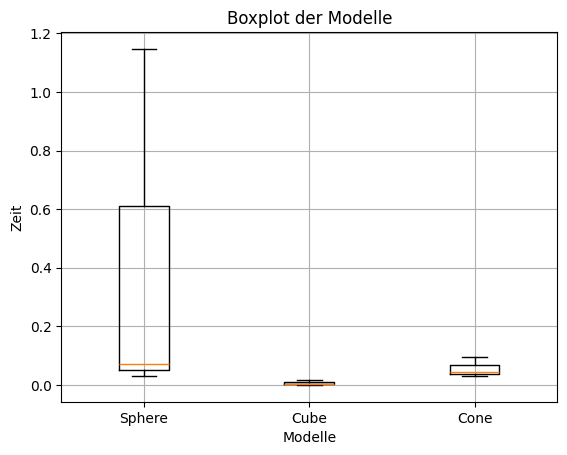

In [102]:
# plot out of times for each model
import matplotlib.pyplot as plt

# Boxplot erstellen
plt.boxplot(rd_times, labels=("cube", "sphere", "cone", "complex_cone", "complex_cube", "complex_sphere", "pencil", "teapot", "book"))
plt.title('Boxplot der Modelle für Random Donsampling')
plt.xlabel('Modelle')
plt.ylabel('Zeit')
plt.grid(True)
plt.show()

[156.43969178199768, 190.5140941143036, 287.0870201587677]
[1.035959005355835, 1.2484381198883057, 1.5510673522949219]
[146.50297164916992, 175.26707315444946, 193.96771955490112]


C:\Users\lockf\AppData\Local\Temp\ipykernel_19348\3907033040.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vf_times, labels=['Sphere', 'Cube', 'Cone'])


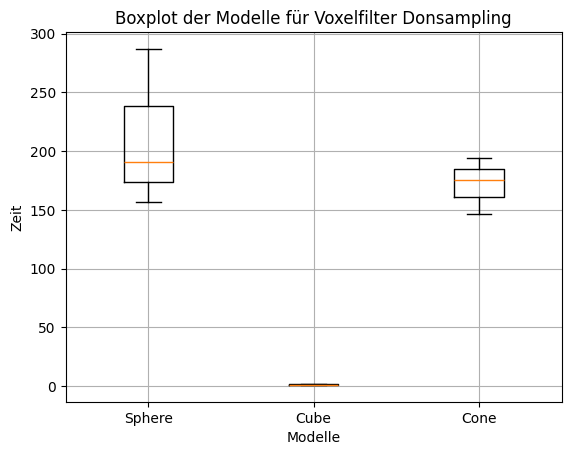

In [105]:
# plot out of times for each model
import matplotlib.pyplot as plt

for times in vf_times:
    print(times)

# Boxplot erstellen
plt.boxplot(vf_times, labels=("cube", "sphere", "cone", "complex_cone", "complex_cube", "complex_sphere", "pencil", "teapot", "book"))
plt.title('Boxplot der Modelle für Voxelfilter Donsampling')
plt.xlabel('Modelle')
plt.ylabel('Zeit')
plt.grid(True)
plt.show()

[33.11591601371765, 38.804004430770874, 50.3848922252655]
[0.015582084655761719, 0.01997995376586914, 0.06254315376281738]
[112.94063806533813, 122.45541620254517, 111.83417320251465]


C:\Users\lockf\AppData\Local\Temp\ipykernel_19348\1477013388.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fp_times, labels=['Sphere', 'Cube', 'Cone'])


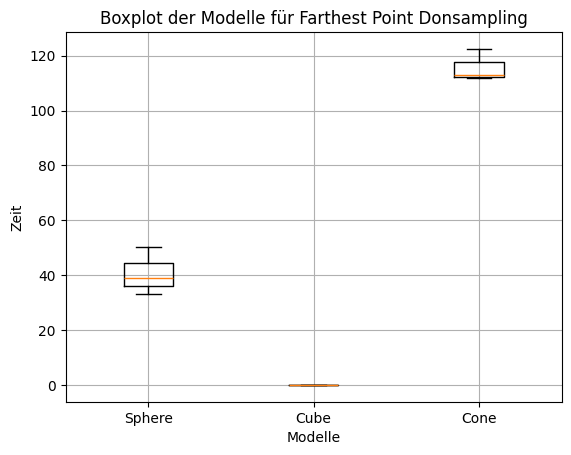

In [106]:
# plot out of times for each model
import matplotlib.pyplot as plt

for times in fp_times:
    print(times)
    
# Boxplot erstellen
plt.boxplot(fp_times, labels=("cube", "sphere", "cone", "complex_cone", "complex_cube", "complex_sphere", "pencil", "teapot", "book"))
plt.title('Boxplot der Modelle für Farthest Point Donsampling')
plt.xlabel('Modelle')
plt.ylabel('Zeit')
plt.grid(True)
plt.show()

ICP Tests

In [99]:
model_array = [cube, sphere, cone, complex_cone, complex_cube, complex_sphere, pencil, teapot, book]
rd_icp = [[] for _ in model_array]  # List of lists for random downsampling times
vf_icp = [[] for _ in model_array]  # List of lists for voxel filter times
fp_icp = [[] for _ in model_array]  # List of lists for farthest point sampling times

# Methode Spalte, Modell Zeile ?
# [][][]    
# [][][]

for round in range(1):
    for i, model in enumerate(model_array):
        try:
             # random downsampling
            method = "random downsampling"
            model_rd= random_downsampling(model, int(len(model.points)/10 * 4))
            model_rd_pc = o3d.geometry.PointCloud()
            model_rd_pc.points = o3d.utility.Vector3dVector(np.asarray(model_rd.points))
            rd_icp[i].append(icp_algorithm(model, model_rd_pc) )    
            
            # voxel grid filter
            method = "voxelgrid filter downsampling"
            model_voxel_grid = create_voxel_grid(model, 0.2)
            model_voxel_pc = o3d.geometry.PointCloud()
            model_voxel_pc.points = voxel_filter(model, model_voxel_grid,0.2)
            vf_icp[i].append(icp_algorithm(model_voxel_pc,model))    
            
            # farthest point downsampling
            method = "farthest point downsampling"
            model_fp = farthest_point_sampling(model,int(len(model.points)/10 * 4))
            model_fp_pc = o3d.geometry.PointCloud()
            model_fp_pc.points = o3d.utility.Vector3dVector(np.asarray(model_fp.points))
            vf_icp[i].append(icp_algorithm(model, model_fp_pc))    
            
        except Exception as e:
            print('Methode:' + method + ' Iteration ' + i + ' Fehlermeldung: ' + e)
            
write_csv(rd_icp,"rd_icp")
write_csv(vf_icp,"vf_icp")
write_csv(fp_icp,"fp_icp")

RegistrationResult with fitness=3.998821e-01, inlier_rmse=0.000000e+00, and correspondence_set size of 2035
Access transformation to get result.


KeyboardInterrupt: 

Plot ICP Random Downsampling

In [ ]:
# plot out of icp for each model
import matplotlib.pyplot as plt

for icp in rd_icp:
    print(icp)
    
# Boxplot erstellen
plt.boxplot(rd_icp, labels=("cube", "sphere", "cone", "complex_cone", "complex_cube", "complex_sphere", "pencil", "teapot", "book"))
plt.title('Boxplot der Modelle für Random Point Downsampling')
plt.xlabel('Modelle')
plt.ylabel('Zeit')
plt.grid(True)
plt.show()

Plot ICP Voxel Grid Filter

In [ ]:
# plot out of icp for each model
import matplotlib.pyplot as plt

for icp in vf_icp:
    print(icp)
    
# Boxplot erstellen
plt.boxplot(rd_icp, labels=("cube", "sphere", "cone", "complex_cone", "complex_cube", "complex_sphere", "pencil", "teapot", "book"))
plt.title('Boxplot der Modelle für Voxel Grid Filter Downsampling')
plt.xlabel('Modelle')
plt.ylabel('Zeit')
plt.grid(True)
plt.show()

Plot Farthest Point Downsampling

In [ ]:
# plot out of icp for each model
import matplotlib.pyplot as plt

for icp in fp_icp:
    print(icp)
    
# Boxplot erstellen
plt.boxplot(rd_icp, labels=("cube", "sphere", "cone", "complex_cone", "complex_cube", "complex_sphere", "pencil", "teapot", "book"))
plt.title('Boxplot der Modelle für Farthest Point Downsampling')
plt.xlabel('Modelle')
plt.ylabel('Zeit')
plt.grid(True)
plt.show()

Noisiness test basic models

In [112]:
model_array = [sphere,cube,cone]
model_names = ["sphere","cube","cone"]
for index, model in enumerate(model_array):
    # create noisy pointclouds
    noisy_model= add_noise(model,1.3)
    visualize_model(noisy_model)
    
    # Random Downsampling
    rd_noisy = random_downsampling(noisy_model,int(len(noisy_model.points)/10 * 4))
    point_cloud_to_ply("noisy_rd_"+model_names[index]+".ply",rd_noisy)

    # Voxel Grid Filter
    noisy_model_grid = create_voxel_grid(noisy_model, 0.2)
    noisy_model_voxel_pc = o3d.geometry.PointCloud()
    noisy_model_voxel_pc.points = voxel_filter(noisy_model, noisy_model_grid,0.2)
    point_cloud_to_ply("noisy_vf_"+model_names[index]+".ply",noisy_model_voxel_pc)
    
    # Farthest Point Downsampling
    noisy_model_fp = farthest_point_sampling(noisy_model,int(len(noisy_model.points)/10 * 4))
    noisy_model_fp_pc = o3d.geometry.PointCloud()
    noisy_model_fp_pc.points = o3d.utility.Vector3dVector(np.asarray(noisy_model_fp.points))
    point_cloud_to_ply("noisy_fp_"+model_names[index]+".ply",noisy_model_fp_pc)


TypeError: can only concatenate str (not "open3d.cpu.pybind.geometry.PointCloud") to str

noisiness tests complex models

In [ ]:
model_array = [complex_sphere,complex_cube,complex_cone]
model_names = ["complex_sphere","complex_cube","complex_cone"]

for complex_model, index in enumerate(model_array):

    noisy_complex_model =add_noise(complex_model,1.3)
    visualize_model(noisy_complex_model)
    rd_complex_noisy = random_downsampling(noisy_complex_model,int(len(noisy_complex_model.points)/10 * 4))
    point_cloud_to_ply(rd_complex_noisy, "noisy_rd_"+model_names[index]+".ply")

    noisy_complex_model_grid = create_voxel_grid(noisy_complex_model, 0.2)
    noisy_complex_model_voxel_pc = o3d.geometry.PointCloud()
    noisy_complex_model_voxel_pc.points = voxel_filter(noisy_complex_model, noisy_complex_model_grid,0.2)
    point_cloud_to_ply(noisy_complex_model_voxel_pc, "noisy_vf_"+model_names[index]+".ply")

    noisy_complex_model_fp = farthest_point_sampling(noisy_complex_model,int(len(noisy_complex_model.points)/10 * 4))
    noisy_complex_model_fp_pc = o3d.geometry.PointCloud()
    noisy_complex_model_fp_pc.points = o3d.utility.Vector3dVector(np.asarray(noisy_complex_model_fp.points))
    point_cloud_to_ply(noisy_complex_model_fp_pc, "noisy_fp_"+model_names[index]+".ply")

noisiness tests objects

In [ ]:
model_array = [teapot,book,pencil]
model_names = ["teapot","book","pencil"]

for model_object, index in enumerate(model_array):
        
    # random downsampling
    noisy_model_object = add_noise(model_object,0.1)
    visualize_model(noisy_model_object)
    rd_noisy = random_downsampling(noisy_model_object, int(len(noisy_model_object.points)/10 * 4))
    point_cloud_to_ply(rd_noisy, "noisy_rd_"+model_names[index]+".ply")

    # voxel grid filter
    noisy_model_object_grid = create_voxel_grid(noisy_model_object, 0.2)
    noisy_object_voxel_pc = o3d.geometry.PointCloud()
    noisy_object_voxel_pc.points = voxel_filter(noisy_model_object, noisy_model_object_grid,0.2)
    point_cloud_to_ply(noisy_object_voxel_pc, "noisy_vf_"+model_names[index]+".ply")

    # farthest point downsampling
    noisy_model_object_fp = farthest_point_sampling(noisy_model_object,int(len(noisy_model_object.points)/10 * 4))
    noisy_model_object_fp_pc = o3d.geometry.PointCloud()
    noisy_model_object_fp_pc.points = o3d.utility.Vector3dVector(np.asarray(noisy_model_object_fp.points))
    point_cloud_to_ply(noisy_model_object_fp_pc, "noisy_fp_"+model_names[index]+".ply")